<a href="https://colab.research.google.com/github/drscook/voting_predictor/blob/main/voting.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>

#Predicting Minority Voting Behavior From Publicly Available Data

- Scott Cook
- Math 5364 Data Science 1
- Tarleton State University
- Spring 2023

##Background
(under construction)

###Goal

Predict voting behavior of distinct racial groups using only publicly available data.  To be continued ...

###Racial Grouping

The US Census includes the two [race and origin questions](https://www.census.gov/newsroom/blogs/random-samplings/2021/08/improvements-to-2020-census-race-hispanic-origin-question-designs.html) below. Note the "one or more" instruction for the second. Thus, a single individual can conceivably have Hispanic origin and be White and Black and Pacific Islander and American Indian and more.

We must group into fewer combinations. Because this project focuses on Texas where White and Hispanic are the largest groups, we will utilize the following grouping:
- White
- Hispanic, non-White (Hisp)
    - an officially recognized "racial iteration" for the American Community Survey
- Non-Hispanic, Non-White (Other)
    - counts for Other will typically be computed via All-White-Hisp

####Hispanic Origin

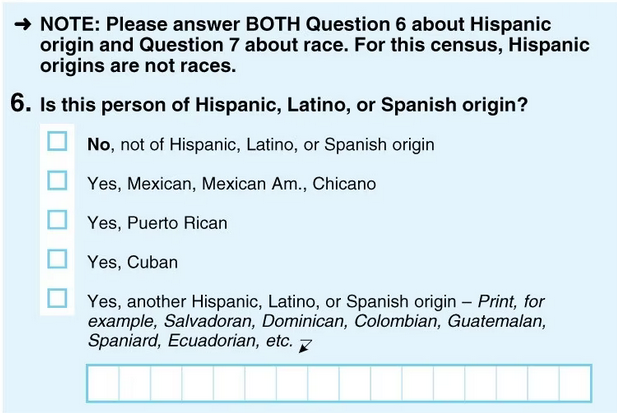

####Race

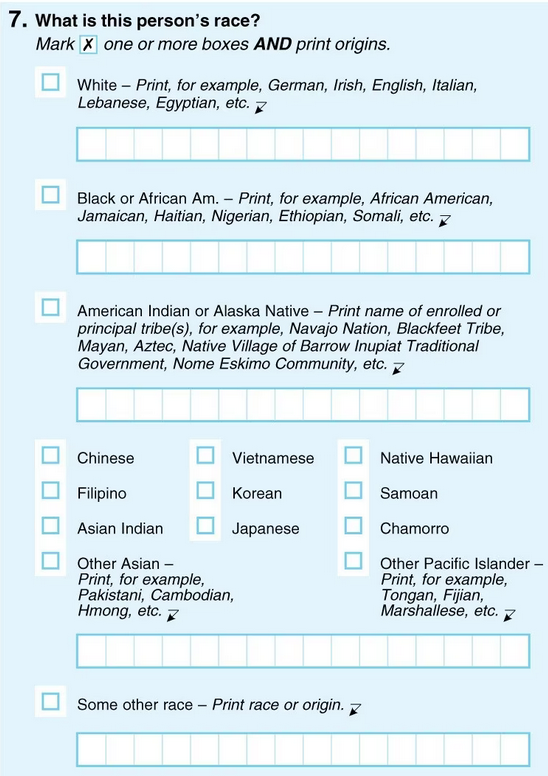

###Geospatial

Since the US Census counts residents at each location, census data is inherantly geospatial. It is critical to understand the [Standard Hierarchy of Census Geographic Entities](https://www2.census.gov/geo/pdfs/reference/geodiagram.pdf) and [geographic identifiers (geoid)](https://www.census.gov/programs-surveys/geography/guidance/geo-identifiers.html).
- US Census Bureau defines boundaries and [geographic identifiers (geoid)](https://www.census.gov/programs-surveys/geography/guidance/geo-identifiers.html) for block, block groups, and tracts, but does NOT control other entities in the hierarchy.
- State governments define boundaries and identifiers for the voting tablulation districts (VTD) that collect election results.
- VTDs do NOT repect tract and block group boundaries. One VTD might span multiple tracts AND one tract might span multiple VTDs (also true for block groups).
- VTDs DO respect block boundaries. Every block is entirely contained in exactly one VTD.
- The US Census Bureau redraws it boundaries for each decennnial census. This creates a significant problem (see Data Wrangling) because this project uses data from before AND after the 2020 redraw.

##Data

###[Texas Legislative Council](https://tlc.texas.gov/)

["A nonpartisan legislative agency that serves as a source of impartial research and information. Its staff assist legislators in drafting and analyzing proposed legislation and in obtaining information on specific legislative problems and on matters affecting the general welfare of the state."](https://tlc.texas.gov/about)

####[Comprehensive Election Datasets](https://data.capitol.texas.gov/dataset/comprehensive-election-datasets-compressed-format)

- Retrieved Dec 21, 2022 via direct download of zip archive
- Results of most Texas elections 2012-2022, including many local and primary elections
- ["Each compressed (.zip) file contains all of the available election data reported by the indicated vintage of voting districts (VTDs)."](https://data.capitol.texas.gov/dataset/comprehensive-election-datasets-compressed-format)
- Important features
    - VTD geoid (str): identifier for voting tabulation district that collected these votes (see Geospatial subsection of Data Wrangling section for details)
    - fips (int): [fips code](https://en.wikipedia.org/wiki/FIPS_county_code) of county containing this VTD
    - office (str): governmental position being elected
    - year (int): election year
    - name (str): candidate's name
    - party (str): candidate's political party
    - incumbent (bool): whether candidate held this office prior to this election
    - votes (int): count of votes received by this candidate in this VTD

###[US Census Bureau](https://www.census.gov/)

["Our mission is to serve as the nation's leading provider of quality data about its people and economy".](https://www.census.gov/about.html) They conducts the decennial nationwide census and many other data collection processes.

####[2020 Decennial Census P.L. 94-171](https://www.census.gov/programs-surveys/decennial-census/about/rdo/summary-files.html)

- Retrieved Dec 19, 2022 using [Census Python package](https://pypi.org/project/census/)
- The Decennial Census occurs once every ten year and counts every US resident at the block (smallest) geospatial level.
- [Public Law (P.L.) 94-171, enacted by Congress in December 1975, requires the Census Bureau to provide states the ... data in order to conduct legislative redistricting and ... to furnish tabulations of population to each state, including for those small areas the states have identified, within one year of Census day.](https://www.census.gov/programs-surveys/decennial-census/about/rdo/summary-files.html)
- As discussed above, the goal is to predict voting behavior for 3 racial groups: white, hispanic non-white (hisp), and non-hispanic non-white (other). To this end, we retrieve data for all, white, and hisp counts and compute other counts by subtraction.
- Important features
    - block geoid (int) - [geographic identifier](https://www.census.gov/programs-surveys/geography/guidance/geo-identifiers.html) of the block where this data was collected
    - all / white / hisp / other total population (int) - count of all / white / hisp / other residents
        - variables p2_001n / p2_005n / p2_002n / p2_001n-p2_005n-p2_002n
    - all / white / hisp / other vap population (int) - count of all / white / hisp / other voting age (≥18) residents
        - variable p4_001n / p4_005n / p4_002n / p4_001n-p4_005n-p4_002n

####[American Community Survey (ACS)](https://www.census.gov/programs-surveys/acs)

- Retrieved Dec 21, 2022 using [Census Python package](https://pypi.org/project/census/)
- Similar to Decennial Census, but conducted every year on a statistically valid sample of the US population
- Collects wide range of demographic, social, and economic features
- Available in 1 year and 5 year estimates.
    - We use 5 year estimates as these more statistically reliable 
    - They are running averages over 5 years tend to diminish the effect of single-year sampling bias.
- Only use ACS features that are available by age and "racial iterations"
    - compute all_tot, all_vap, white_tot, white_vap, hisp_tot, hisp_vap, other_tot, and other_vap values for each feature
    - other (non-hispanic non-white) counts computed by subtraction as discussed above
- ACS variable numbers differ from the Decennial Census.  Moreover, many ACS features are given in small age ranges (ex: 18-24) which necesitates summing many raw features to produce our desired value.  See [constants.py](https://github.com/drscook/voting_predictor/blob/main/voting_predictor/constants.py) for details.
- Important features
    - tract geoid (int) - [geographic identifier](https://www.census.gov/programs-surveys/geography/guidance/geo-identifiers.html) of the tract where this data was collected
        - Due to privacy concerns, most ACS features are not released at the block (smallest) geographic level.  ACS is aggegrated to the tract level (see Background-Geospatial)
    - all populations listed for Decennial Census
    - elderly (int) - count of residents ≥55
    - poverty (int) count of residents with income in last 12 months below poverty level
    - highschool (int) - count of residents with a high school diploma or equivalent
    - homeowner (int) - count of owner occupied housing units
    - english fluency - propotion of residents that speak Spanish at home who also speak English well or very well

####[TIGER/Line Shapefiles](https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html)

- Retrieved Dec 19, 2022 via direct download
- TIGER: Topologically Integrated Geographic Encoding and
Referencing
- ["...include polygon boundaries of geographic areas and features linear features including roads and hydrography, and point features"](https://www2.census.gov/geo/pdfs/maps-data/data/tiger/tgrshp_rd18/TGRSHPRD18_TechDoc.pdf)
- Provides geospatial polygon data for blocks
- Important features
    - block geoid (int) - [geographic identifier](https://www.census.gov/programs-surveys/geography/guidance/geo-identifiers.html) of the block this polygon describes
    - aland (float) - land area within block in m^2
    - awater (float) - water area within block in m^2
    - geometry (geometry) - list of (lon, lat) points that form the boundary of this block



####[Block Assignment Files](https://www.census.gov/geographies/reference-files/time-series/geo/block-assignment-files.html)

- Retrieved Dec 19, 2022 via direct download
- For each block, indicates which US congressional, state senate, state house, and voting tabulation district contains it
- Important features
    - block geoid (int) - [geographic identifier](https://www.census.gov/programs-surveys/geography/guidance/geo-identifiers.html) of the block
    - congress (int) - US congressional district
    - senate (int) - state senate district
    - house (int) - state house district
    - vtd (str) - voting tabulation district
        - vtd is a string because vtd identifiers may contain non-numeric characters


####[Crosswalks](https://www.census.gov/geographies/reference-files/time-series/geo/relationship-files.html)

- Retrieved Dec 19, 2022 via direct download
- Block shapes are redrawn for each decennial census to reflect population density changes. This creates problems when combining data before and after the redrawing process
- Crosswalks are the intersectional area of all pairs of 2010 block and 2020 blocks
- Important features
    - 2010 block geoid (int) - [geographic identifier](https://www.census.gov/programs-surveys/geography/guidance/geo-identifiers.html) of the 2010 block
    - 2020 block geoid (int) - [geographic identifier](https://www.census.gov/programs-surveys/geography/guidance/geo-identifiers.html) of the 2020 block
    - aland - area (in m^2) of the intersection of the 2010 and 2020 blocks

##Data Wrangling
(under construction)

The code for extract, load, and transform (ETL) is substantial and stored this  Github repo: https://github.com/drscook/voting_predictor. Here are the major data wrangling challenges and solutions.

The major data wrangling obstacles are:
1. Geospatially unify pre and post 2020 ACS and election data, recalling that Census geographies were redrawn for the 2020 Census
    - Use crosswalks at smallest geographic level (block) to minimize induced error
    - Must compute other=all-white=hisp *before* applying transform
1. VTD's where TX Legislative Council reports more votes than Census Bureau reports  residents
    - Spot checks of case were explainablt by large population influx (ex: opening large apartment building after ACS count and before election day)
1. VTD geoid's report by the Texas Legislative Council and Census Bureau do not fully agree.
    - Solved attempting join between election results \& Census data twice, with a character insertion and shift.  This 2 round approach join more than 99.9% of data.
1. Entire process takes about 40 minutes on BigQuery \& Colab
    - Geometry shapefiles are particularly time consuming
1. Numerous small irritants like inconsisten column names, find download URLs, divide by zero errors caused by blocks or VTDs with 0 population

###Unify pre and post 2020 ACS and election data

As discusses in Background-Geospatial, census and election data are tied to specific locations, which makes them inherently geospatial. The 

#Code

In [ ]:
! pip install -q 'git+https://github.com/drscook/voting_predictor'

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 83.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 102.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 KB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.6/132.6 KB 15.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 76.0 MB/s eta 0:00:00


In [ ]:
%reload_ext google.colab.data_table
%reload_ext autotime
%reload_ext autoreload
%autoreload 2
# run only to pull changes to these repos
# ! pip install -q  --upgrade --force-reinstall --no-cache-dir --no-deps 'git+https://github.com/drscook/helpers'
# ! pip install -q  --upgrade --force-reinstall --no-cache-dir --no-deps 'git+https://github.com/drscook/voting_predictor'
from helpers.common_imports import *
import helpers.utilities as ut, voting_predictor as vp
root_path = ut.mount_drive() / 'gerrymandering/2022-12'
votes = vp.Voting(
    census_api_key = 'dccb7bb4b7df5dff59d2d99c859016f973197e4e',
    bq_project_id = 'redistricting-361203',
    state = 'TX',
    level = 'vtd',
    root_path = root_path,
    refresh = [
        # 'acs5',
        # 'acs5_transformed',
        # 'assignments',
        # 'crosswalks',
        # 'crosswalks_raw',
        # 'elections',
        # 'elections_raw',
        # 'final',
        # 'geo',
        # 'geo_raw',
        # 'pl',
        # 'plans',
        # 'transformer',
        # 'shapes',
    ])
print(votes.refresh)
tbl = votes.get_final()
df = votes.bq.tbl_to_df(tbl, rows=-1)


Mounted at /content/drive


set()


In [ ]:
df['urbanization'] = df.groupby('campaign')['all_vap_pop_dens'].transform(lambda x: pd.qcut(x, 3, labels=['rural', 'suburban', 'urban']))

race       = ['hisp', 'other', 'white']
party      = ['dem', 'rep']
wghts      = [f'{r}_vap_pop'        for p in party for r in race]
props_race = [f'{p}_{r}_prop_pred'  for p in party for r in race]
votes_race = [f'{p}_{r}_votes_pred' for p in party for r in race]
props_tot  = [f'{p}_prop_pred'      for p in party]
votes_tot  = [f'{p}_votes_pred'     for p in party]
targs      = [f'{p}_votes'          for p in party]
meta  = ['year', 'vtd2020', 'county2020', 'campaign', 'candidates', 'urbanization']
feats = [
    # 'year',
    # 'vtd2020',
    # 'county2020',
    # 'aland',
    # 'awater',
    # 'atot',
    # 'perim',
    # 'polsby_popper',
    # 'all_tot_pop',
    # 'all_tot_pop_dens',
    # 'all_tot_pop_dens_rel',
    # 'all_tot_pop_prop',
    # 'all_vap_elderly',
    # 'all_vap_elderly_prop',
    # 'all_vap_highschool',
    # 'all_vap_highschool_prop',
    # 'all_vap_homeowner',
    # 'all_vap_homeowner_prop',
    # 'all_vap_pop',
    # 'all_vap_pop_dens',
    'all_vap_pop_dens_rel',
    # 'all_vap_pop_prop',
    # 'all_vap_poverty',
    # 'all_vap_poverty_prop',
    # 'dist_to_border',
    'dist_to_border_rel',
    # 'hisp_tot_pop',
    # 'hisp_tot_pop_dens',
    # 'hisp_tot_pop_dens_rel',
    # 'hisp_tot_pop_prop',
    # 'hisp_vap_elderly',
    'hisp_vap_elderly_prop',
    # 'hisp_vap_highschool',
    'hisp_vap_highschool_prop',
    # 'hisp_vap_homeowner',
    'hisp_vap_homeowner_prop',
    # 'hisp_vap_pop',
    # 'hisp_vap_pop_dens',
    # 'hisp_vap_pop_dens_rel',
    'hisp_vap_pop_prop',
    # 'hisp_vap_poverty',
    'hisp_vap_poverty_prop',
    # 'hisp_vap_spanishathome',
    'hisp_vap_spanishathome_prop',
    # 'hisp_vap_spanishathomeenglishwell',
    'hisp_vap_spanishathomeenglishwell_prop',
    # 'other_tot_pop',
    # 'other_tot_pop_dens',
    # 'other_tot_pop_dens_rel',
    # 'other_tot_pop_prop',
    # 'other_vap_elderly',
    'other_vap_elderly_prop',
    # 'other_vap_highschool',
    'other_vap_highschool_prop',
    # 'other_vap_homeowner',
    'other_vap_homeowner_prop',
    # 'other_vap_pop',
    # 'other_vap_pop_dens',
    # 'other_vap_pop_dens_rel',
    'other_vap_pop_prop',
    # 'other_vap_poverty',
    'other_vap_poverty_prop',
    # 'white_tot_pop',
    # 'white_tot_pop_dens',
    # 'white_tot_pop_dens_rel',
    # 'white_tot_pop_prop',
    # 'white_vap_elderly',
    'white_vap_elderly_prop',
    # 'white_vap_highschool',
    'white_vap_highschool_prop',
    # 'white_vap_homeowner',
    'white_vap_homeowner_prop',
    # 'white_vap_pop',
    # 'white_vap_pop_dens',
    # 'white_vap_pop_dens_rel',
    'white_vap_pop_prop',
    # 'white_vap_poverty',
    'white_vap_poverty_prop',
    # 'campaign',
    # 'candidates',
    # 'dem_votes',
    # 'rep_votes',
    # 'tot_votes',
    # 'dem_prop',
    # 'rep_prop',
]



 rural 20 ['ReLU', 'Sigmoid']


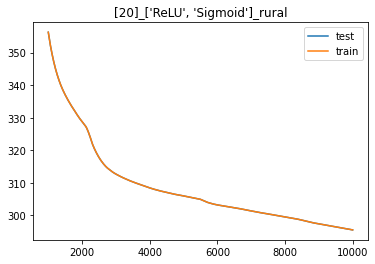

[20]_['ReLU', 'Sigmoid']_rural rural 20 ['ReLU', 'Sigmoid'] 198.0673554391226 295.5097819869928


 rural 21 ['ReLU', 'Sigmoid']


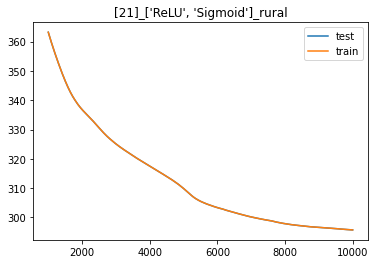

[21]_['ReLU', 'Sigmoid']_rural rural 21 ['ReLU', 'Sigmoid'] 198.00893153133322 295.76283784478403


 rural 22 ['ReLU', 'Sigmoid']


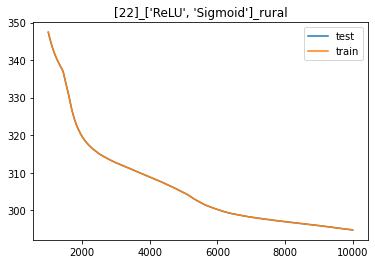

[22]_['ReLU', 'Sigmoid']_rural rural 22 ['ReLU', 'Sigmoid'] 198.89231552079735 294.7703025238465


 rural 23 ['ReLU', 'Sigmoid']


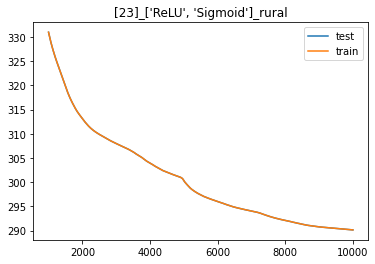

[23]_['ReLU', 'Sigmoid']_rural rural 23 ['ReLU', 'Sigmoid'] 198.16241092799626 290.13395343789045


 rural 24 ['ReLU', 'Sigmoid']


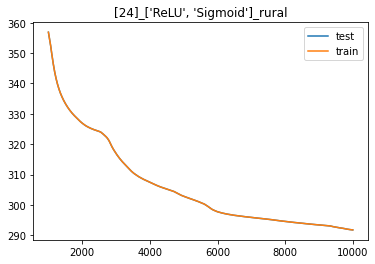

[24]_['ReLU', 'Sigmoid']_rural rural 24 ['ReLU', 'Sigmoid'] 199.13467952775088 291.8028818826161


 rural 25 ['ReLU', 'Sigmoid']


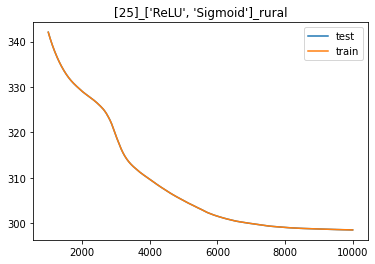

[25]_['ReLU', 'Sigmoid']_rural rural 25 ['ReLU', 'Sigmoid'] 198.66810867923002 298.4879342201289


 rural 26 ['ReLU', 'Sigmoid']


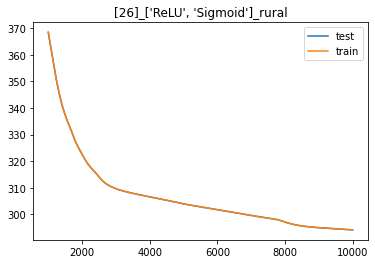

[26]_['ReLU', 'Sigmoid']_rural rural 26 ['ReLU', 'Sigmoid'] 197.8799325930168 294.1601392099208


 rural 27 ['ReLU', 'Sigmoid']


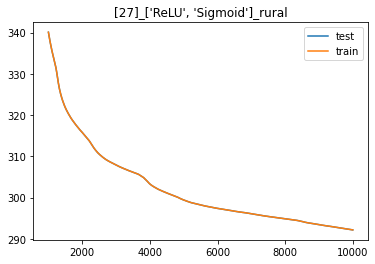

[27]_['ReLU', 'Sigmoid']_rural rural 27 ['ReLU', 'Sigmoid'] 196.98811848806088 292.181958503601


 rural 28 ['ReLU', 'Sigmoid']


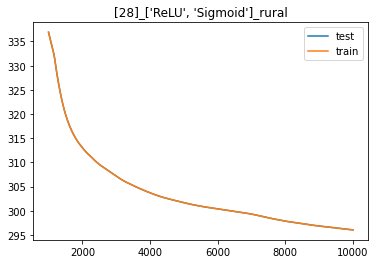

[28]_['ReLU', 'Sigmoid']_rural rural 28 ['ReLU', 'Sigmoid'] 196.24212613996923 296.0440608042999


 rural 29 ['ReLU', 'Sigmoid']


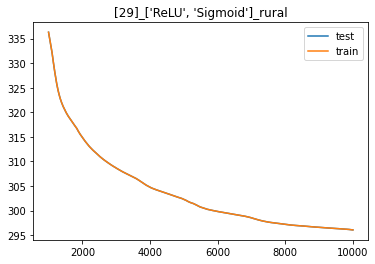

[29]_['ReLU', 'Sigmoid']_rural rural 29 ['ReLU', 'Sigmoid'] 196.44023177148225 296.0787611641538


 rural 30 ['ReLU', 'Sigmoid']


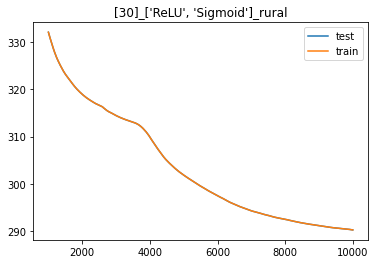

[30]_['ReLU', 'Sigmoid']_rural rural 30 ['ReLU', 'Sigmoid'] 194.30939275953895 290.2687736176594


 rural 31 ['ReLU', 'Sigmoid']


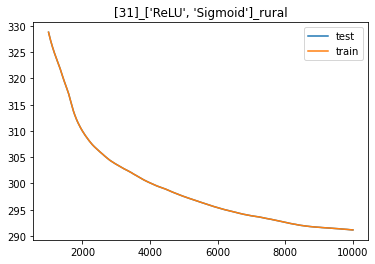

[31]_['ReLU', 'Sigmoid']_rural rural 31 ['ReLU', 'Sigmoid'] 196.28366121717326 291.1565032332268


 rural 32 ['ReLU', 'Sigmoid']


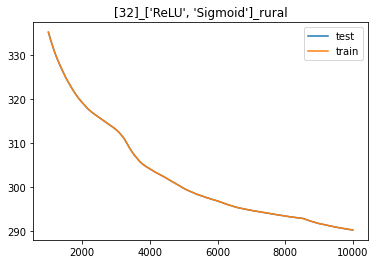

[32]_['ReLU', 'Sigmoid']_rural rural 32 ['ReLU', 'Sigmoid'] 196.9128579634376 290.2612374008972


 rural 33 ['ReLU', 'Sigmoid']


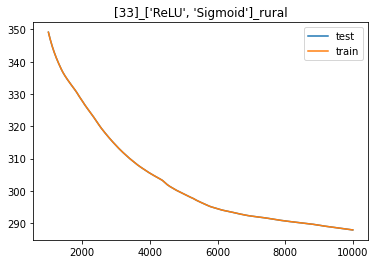

[33]_['ReLU', 'Sigmoid']_rural rural 33 ['ReLU', 'Sigmoid'] 198.06382918305218 287.9003462571728


 rural 34 ['ReLU', 'Sigmoid']


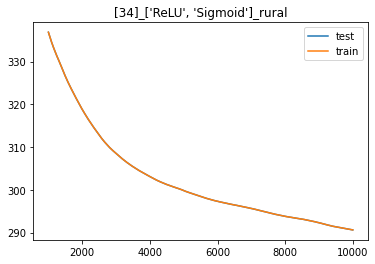

[34]_['ReLU', 'Sigmoid']_rural rural 34 ['ReLU', 'Sigmoid'] 195.51945953264976 290.6328493563658


 rural 35 ['ReLU', 'Sigmoid']


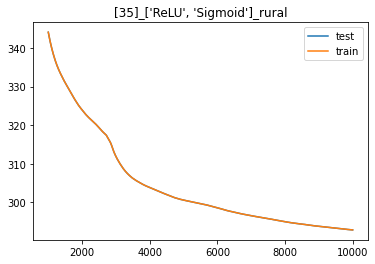

[35]_['ReLU', 'Sigmoid']_rural rural 35 ['ReLU', 'Sigmoid'] 195.72195729497966 292.88492300731355


 rural 36 ['ReLU', 'Sigmoid']


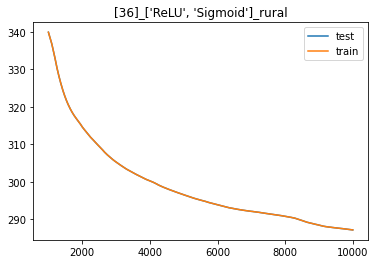

[36]_['ReLU', 'Sigmoid']_rural rural 36 ['ReLU', 'Sigmoid'] 197.12897511653276 287.19448440908474


 rural 37 ['ReLU', 'Sigmoid']


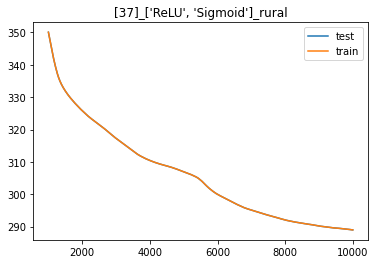

[37]_['ReLU', 'Sigmoid']_rural rural 37 ['ReLU', 'Sigmoid'] 193.71642167540904 288.99710746822365


 rural 38 ['ReLU', 'Sigmoid']


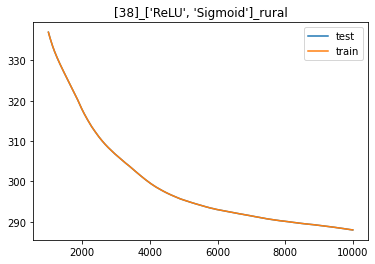

[38]_['ReLU', 'Sigmoid']_rural rural 38 ['ReLU', 'Sigmoid'] 193.88249688690138 287.99914550654483


 rural 39 ['ReLU', 'Sigmoid']


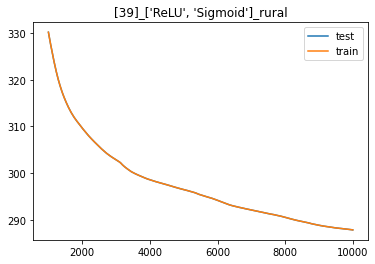

[39]_['ReLU', 'Sigmoid']_rural rural 39 ['ReLU', 'Sigmoid'] 193.49052057379592 287.8357686033826


 suburban 20 ['ReLU', 'Sigmoid']


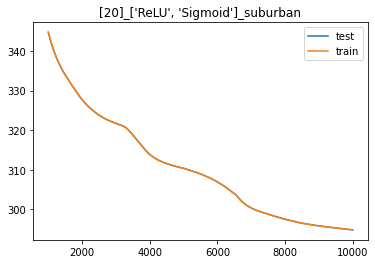

[20]_['ReLU', 'Sigmoid']_suburban suburban 20 ['ReLU', 'Sigmoid'] 356.55393284851175 294.81099612717975


 suburban 21 ['ReLU', 'Sigmoid']


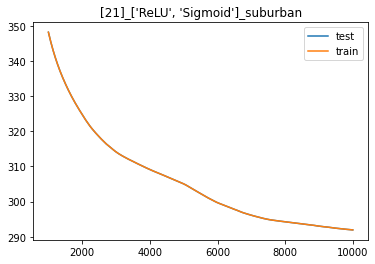

[21]_['ReLU', 'Sigmoid']_suburban suburban 21 ['ReLU', 'Sigmoid'] 355.8333438604392 291.9325558883421


 suburban 22 ['ReLU', 'Sigmoid']


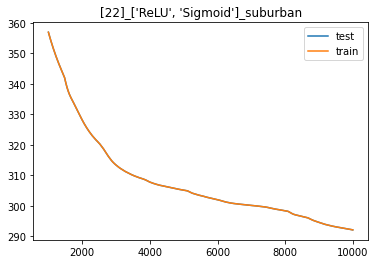

[22]_['ReLU', 'Sigmoid']_suburban suburban 22 ['ReLU', 'Sigmoid'] 355.5129890762234 292.1454715762338


 suburban 23 ['ReLU', 'Sigmoid']


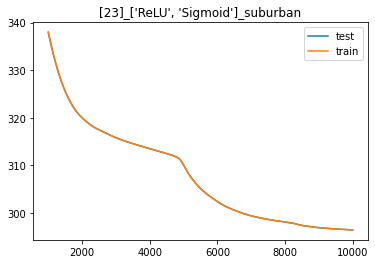

[23]_['ReLU', 'Sigmoid']_suburban suburban 23 ['ReLU', 'Sigmoid'] 356.0438120260643 296.4661922125354


 suburban 24 ['ReLU', 'Sigmoid']


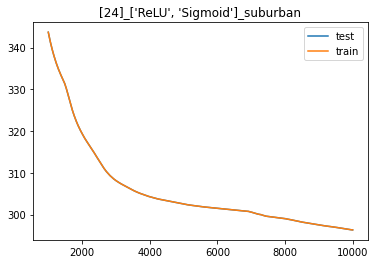

[24]_['ReLU', 'Sigmoid']_suburban suburban 24 ['ReLU', 'Sigmoid'] 354.6223641832779 296.30790573320854


 suburban 25 ['ReLU', 'Sigmoid']


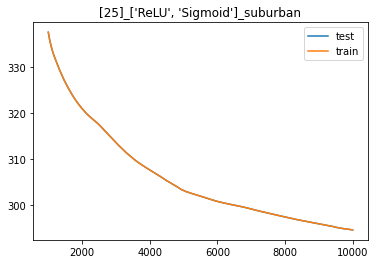

[25]_['ReLU', 'Sigmoid']_suburban suburban 25 ['ReLU', 'Sigmoid'] 357.54777467748823 294.63982249519495


 suburban 26 ['ReLU', 'Sigmoid']


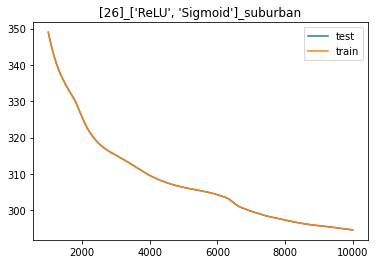

[26]_['ReLU', 'Sigmoid']_suburban suburban 26 ['ReLU', 'Sigmoid'] 353.9019298232939 294.59441133107055


 suburban 27 ['ReLU', 'Sigmoid']


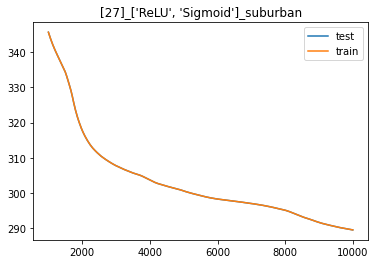

[27]_['ReLU', 'Sigmoid']_suburban suburban 27 ['ReLU', 'Sigmoid'] 355.5477597144069 289.57603707834664


 suburban 28 ['ReLU', 'Sigmoid']


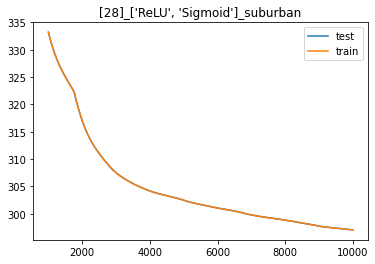

[28]_['ReLU', 'Sigmoid']_suburban suburban 28 ['ReLU', 'Sigmoid'] 352.9293744680383 297.0500668027193


 suburban 29 ['ReLU', 'Sigmoid']


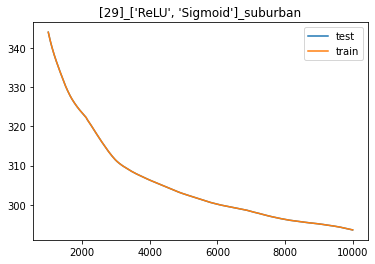

[29]_['ReLU', 'Sigmoid']_suburban suburban 29 ['ReLU', 'Sigmoid'] 351.2410724978046 293.55411021649826


 suburban 30 ['ReLU', 'Sigmoid']


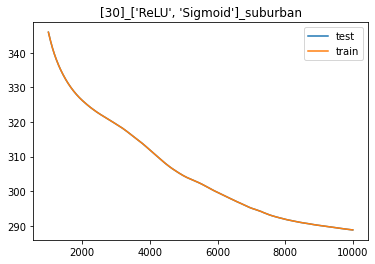

[30]_['ReLU', 'Sigmoid']_suburban suburban 30 ['ReLU', 'Sigmoid'] 350.63043175463133 288.78193816875046


 suburban 31 ['ReLU', 'Sigmoid']


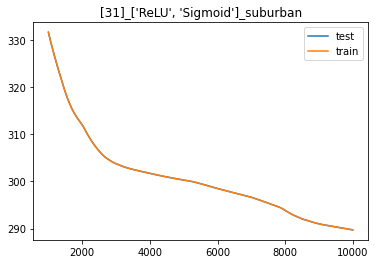

[31]_['ReLU', 'Sigmoid']_suburban suburban 31 ['ReLU', 'Sigmoid'] 351.44958102693505 289.729561401663


 suburban 32 ['ReLU', 'Sigmoid']


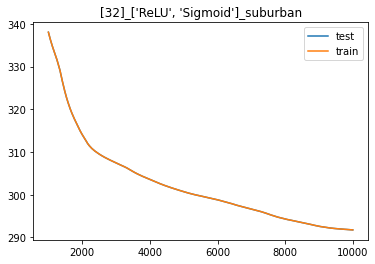

[32]_['ReLU', 'Sigmoid']_suburban suburban 32 ['ReLU', 'Sigmoid'] 351.12926979941443 291.7538158490819


 suburban 33 ['ReLU', 'Sigmoid']


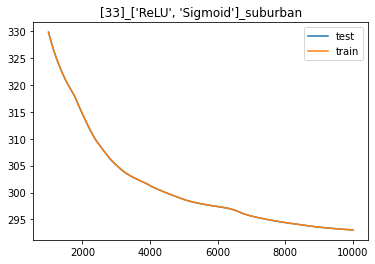

[33]_['ReLU', 'Sigmoid']_suburban suburban 33 ['ReLU', 'Sigmoid'] 349.4979916662355 293.0322214578117


 suburban 34 ['ReLU', 'Sigmoid']


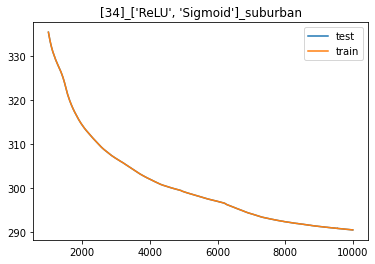

[34]_['ReLU', 'Sigmoid']_suburban suburban 34 ['ReLU', 'Sigmoid'] 349.39749897032607 290.4712631010166


 suburban 35 ['ReLU', 'Sigmoid']


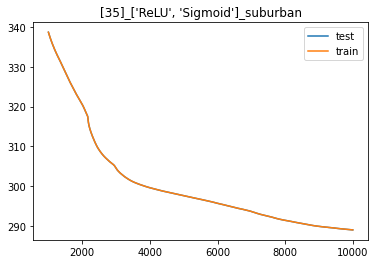

[35]_['ReLU', 'Sigmoid']_suburban suburban 35 ['ReLU', 'Sigmoid'] 350.9428650877679 289.0891676887946


 suburban 36 ['ReLU', 'Sigmoid']


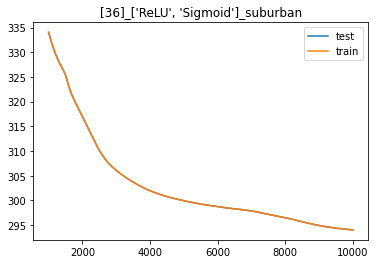

[36]_['ReLU', 'Sigmoid']_suburban suburban 36 ['ReLU', 'Sigmoid'] 350.68346396536367 294.01886631643214


 suburban 37 ['ReLU', 'Sigmoid']


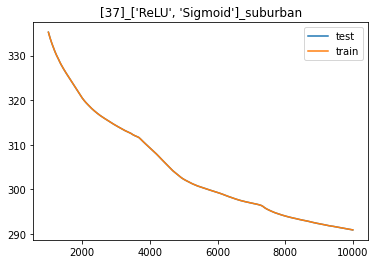

[37]_['ReLU', 'Sigmoid']_suburban suburban 37 ['ReLU', 'Sigmoid'] 348.71063778263056 290.8811639871169


 suburban 38 ['ReLU', 'Sigmoid']


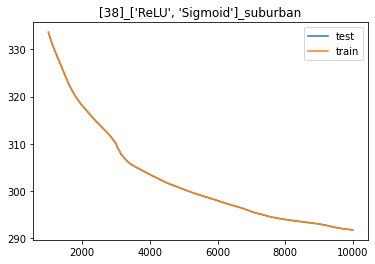

[38]_['ReLU', 'Sigmoid']_suburban suburban 38 ['ReLU', 'Sigmoid'] 346.33660780109335 291.77282740601464


 suburban 39 ['ReLU', 'Sigmoid']


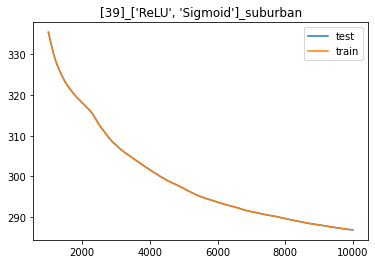

[39]_['ReLU', 'Sigmoid']_suburban suburban 39 ['ReLU', 'Sigmoid'] 350.1821175173267 286.8082983457766


 urban 20 ['ReLU', 'Sigmoid']


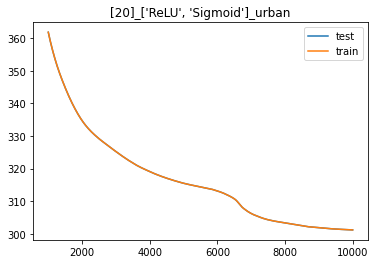

[20]_['ReLU', 'Sigmoid']_urban urban 20 ['ReLU', 'Sigmoid'] 318.4440561093104 301.2378239240551


 urban 21 ['ReLU', 'Sigmoid']


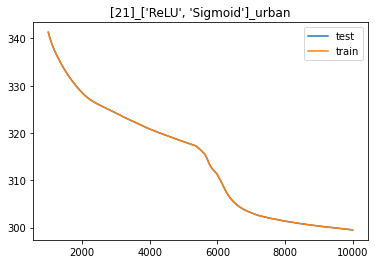

[21]_['ReLU', 'Sigmoid']_urban urban 21 ['ReLU', 'Sigmoid'] 317.312546233382 299.5187937550831


 urban 22 ['ReLU', 'Sigmoid']


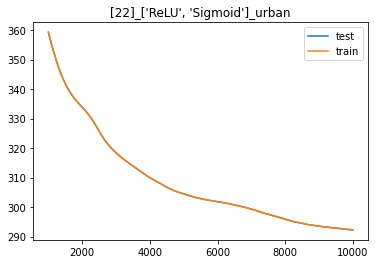

[22]_['ReLU', 'Sigmoid']_urban urban 22 ['ReLU', 'Sigmoid'] 316.5013238032604 292.28148889384016


 urban 23 ['ReLU', 'Sigmoid']


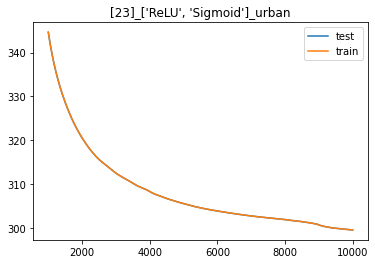

[23]_['ReLU', 'Sigmoid']_urban urban 23 ['ReLU', 'Sigmoid'] 314.3928962021831 299.52082826157516


 urban 24 ['ReLU', 'Sigmoid']


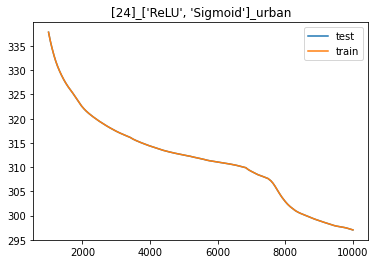

[24]_['ReLU', 'Sigmoid']_urban urban 24 ['ReLU', 'Sigmoid'] 317.897504894897 297.03319469379176


 urban 25 ['ReLU', 'Sigmoid']


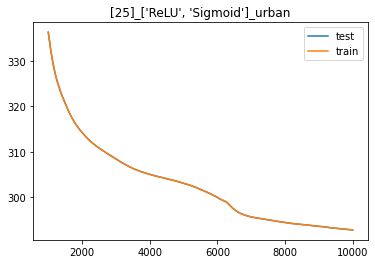

[25]_['ReLU', 'Sigmoid']_urban urban 25 ['ReLU', 'Sigmoid'] 312.6581096798143 292.7760849821925


 urban 26 ['ReLU', 'Sigmoid']


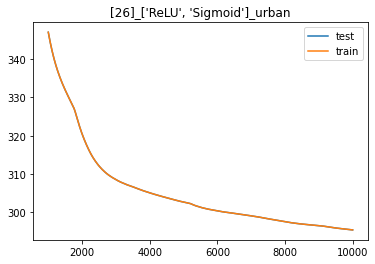

[26]_['ReLU', 'Sigmoid']_urban urban 26 ['ReLU', 'Sigmoid'] 314.0479842716395 295.3999275346898


 urban 27 ['ReLU', 'Sigmoid']


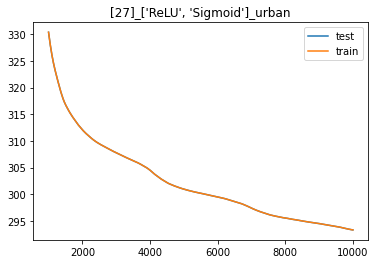

[27]_['ReLU', 'Sigmoid']_urban urban 27 ['ReLU', 'Sigmoid'] 312.5136803535826 293.3344534187895


 urban 28 ['ReLU', 'Sigmoid']


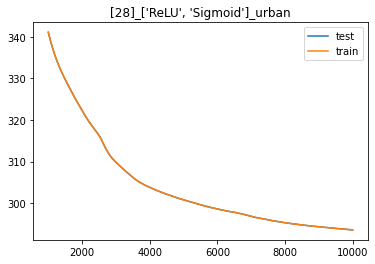

[28]_['ReLU', 'Sigmoid']_urban urban 28 ['ReLU', 'Sigmoid'] 312.0121837481991 293.5736305639524


 urban 29 ['ReLU', 'Sigmoid']


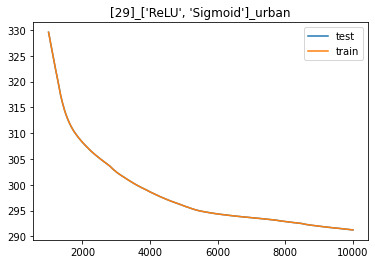

[29]_['ReLU', 'Sigmoid']_urban urban 29 ['ReLU', 'Sigmoid'] 313.8412467917375 291.2416978430458


 urban 30 ['ReLU', 'Sigmoid']


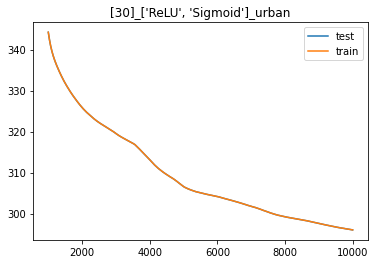

[30]_['ReLU', 'Sigmoid']_urban urban 30 ['ReLU', 'Sigmoid'] 311.18112866586546 296.00034311635517


 urban 31 ['ReLU', 'Sigmoid']


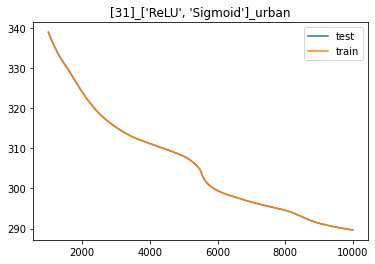

[31]_['ReLU', 'Sigmoid']_urban urban 31 ['ReLU', 'Sigmoid'] 312.334645711519 289.66854711462895


 urban 32 ['ReLU', 'Sigmoid']


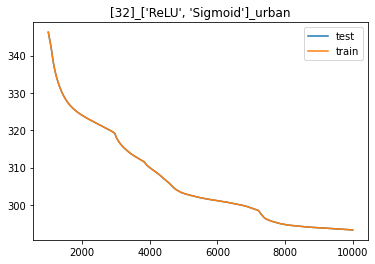

[32]_['ReLU', 'Sigmoid']_urban urban 32 ['ReLU', 'Sigmoid'] 311.5018487371954 293.300467204708


 urban 33 ['ReLU', 'Sigmoid']


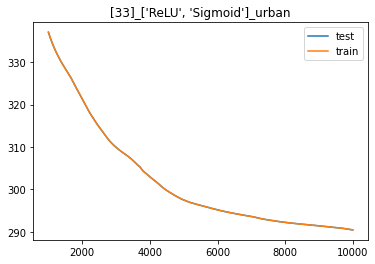

[33]_['ReLU', 'Sigmoid']_urban urban 33 ['ReLU', 'Sigmoid'] 312.6236692290701 290.4202235554542


 urban 34 ['ReLU', 'Sigmoid']


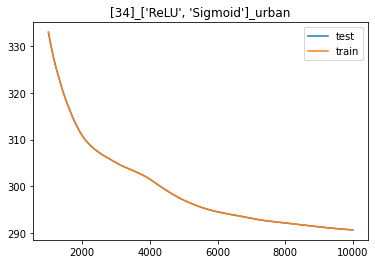

[34]_['ReLU', 'Sigmoid']_urban urban 34 ['ReLU', 'Sigmoid'] 309.0120839008151 290.73112309744204


 urban 35 ['ReLU', 'Sigmoid']


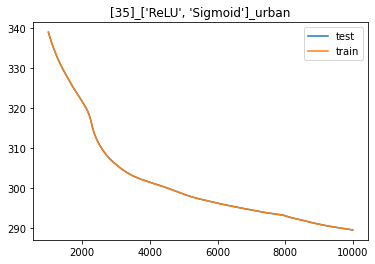

[35]_['ReLU', 'Sigmoid']_urban urban 35 ['ReLU', 'Sigmoid'] 307.3667610155631 289.543093726996


 urban 36 ['ReLU', 'Sigmoid']


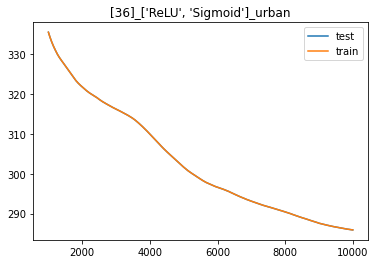

[36]_['ReLU', 'Sigmoid']_urban urban 36 ['ReLU', 'Sigmoid'] 308.09172484919634 285.9270831435875


 urban 37 ['ReLU', 'Sigmoid']


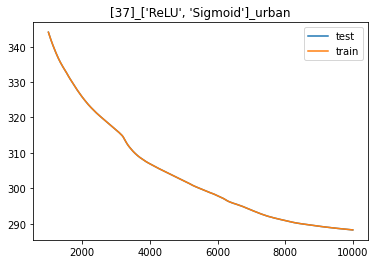

[37]_['ReLU', 'Sigmoid']_urban urban 37 ['ReLU', 'Sigmoid'] 309.53529152695734 288.23983611742494


 urban 38 ['ReLU', 'Sigmoid']


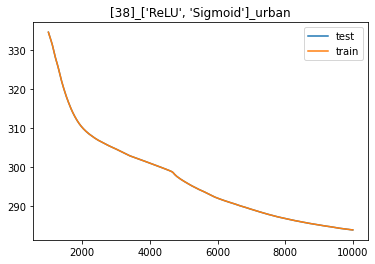

[38]_['ReLU', 'Sigmoid']_urban urban 38 ['ReLU', 'Sigmoid'] 307.72154474010154 283.9694910989559


 urban 39 ['ReLU', 'Sigmoid']


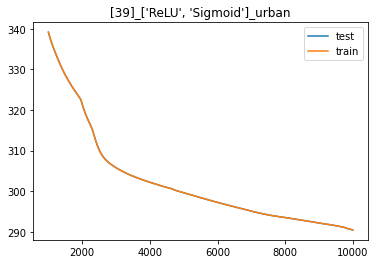

[39]_['ReLU', 'Sigmoid']_urban urban 39 ['ReLU', 'Sigmoid'] 306.7391525245861 290.45099629713786


,name,urbanization,hidden_sizes,activations,cv_score,refit_score
0,"[20]_['ReLU', 'Sigmoid']_rural",rural,20,"[ReLU, Sigmoid]",198.1,295.5
1,"[21]_['ReLU', 'Sigmoid']_rural",rural,21,"[ReLU, Sigmoid]",198.0,295.8
2,"[22]_['ReLU', 'Sigmoid']_rural",rural,22,"[ReLU, Sigmoid]",198.9,294.8
3,"[23]_['ReLU', 'Sigmoid']_rural",rural,23,"[ReLU, Sigmoid]",198.2,290.1
4,"[24]_['ReLU', 'Sigmoid']_rural",rural,24,"[ReLU, Sigmoid]",199.1,291.8
5,"[25]_['ReLU', 'Sigmoid']_rural",rural,25,"[ReLU, Sigmoid]",198.7,298.5
6,"[26]_['ReLU', 'Sigmoid']_rural",rural,26,"[ReLU, Sigmoid]",197.9,294.2
7,"[27]_['ReLU', 'Sigmoid']_rural",rural,27,"[ReLU, Sigmoid]",197.0,292.2
8,"[28]_['ReLU', 'Sigmoid']_rural",rural,28,"[ReLU, Sigmoid]",196.2,296.0
9,"[29]_['ReLU', 'Sigmoid']_rural",rural,29,"[ReLU, Sigmoid]",196.4,296.1


In [ ]:
import torch
torch.manual_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"

def tensorify(T):
    if not torch.is_tensor(T):
        T = torch.FloatTensor(np.array(T).astype(float)).to(device)
    return T

class VotingPredictor(torch.nn.Module):
    def __init__(self, hidden_layers, activations, name=''):
        super().__init__()
        H = ut.listify(hidden_layers)
        A = ut.listify(activations)
        assert len(A) - len(H) == 1, 'activations must be one longer than hidden_layers'
        L = [len(feats), *H, 6]
        N = [x for k, f in enumerate(A) for x in [torch.nn.Linear(L[k], L[k+1]), f()]]
        self.nn = torch.nn.Sequential(*N)
        self.P = tensorify([[1,1,1,0,0,0],[0,0,0,1,1,1]]).T
        self.loss = {'train':[], 'test':[]}
        self.name = f'{H}_{[f.__name__ for f in A]}_{name}'

    def forward(self, W, X):
        self.props_race = self.nn(tensorify(X))
        self.votes_race = self.props_race * tensorify(W)
        self.votes_tot  = self.votes_race @ self.P
        return self.votes_tot

    def train(self, DFS, n_steps, plot=False):
        W = {s:tensorify(df[wghts]) for s,df in DFS.items()}
        X = {s:tensorify(df[feats]) for s,df in DFS.items()}
        Y = {s:tensorify(df[targs]) for s,df in DFS.items()}
        loss_fcn = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(self.nn.parameters())
        def f(s):
            loss = loss_fcn(self.forward(W[s], X[s]), Y[s])
            self.loss[s].append(np.sqrt(loss.item()))
            return loss
        for step in range(n_steps):
            with torch.no_grad():
                f('test')
            loss = f('train')
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        self.score = self.loss['test'][-1]

    def predict(self, df):
        self.forward(df[wghts], df[feats])
        self.props_tot = self.votes_tot / self.votes_tot.sum(axis=1, keepdims=True)
        PR = pd.DataFrame(self.props_race.numpy(force=True), columns=props_race)
        VR = pd.DataFrame(self.votes_race.numpy(force=True), columns=votes_race)
        PT = pd.DataFrame(self.props_tot .numpy(force=True), columns=props_tot)
        VT = pd.DataFrame(self.votes_tot .numpy(force=True), columns=votes_tot)
        return pd.concat([df, VR, PR, VT, PT], axis=1)

    def plot(self, start=0):
        for s in ['test', 'train']:
            y = self.loss[s]
            x = np.arange(len(y))
            plt.plot(x[start:], y[start:], label=s)
        plt.legend()
        plt.title(self.name)
        plt.show()


grid = {
    'hidden_layers':np.arange(20,40),
    'activations': [[torch.nn.ReLU, torch.nn.Sigmoid]]#[torch.nn.ReLU, torch.nn.ReLU], [torch.nn.ReLU, torch.nn.Tanh]],
}

n_steps = 10000
# n_steps = 1000
start = int(n_steps*.1)

results = dict()
summary = list()
for urb, urb_df in df.groupby('urbanization'):
    results[urb] = ut.cartesian(grid)
    for g in results[urb]:
        msg = [urb, g['hidden_layers'], [f.__name__ for f in g['activations']]]
        print('\n\n', *msg)
        g['cv'] = dict()
        for camp, camp_df in urb_df.groupby('campaign'):
            DFS = {'test':camp_df, 'train':urb_df.loc[urb_df.index.difference(camp_df.index)]}
            model = VotingPredictor(g['hidden_layers'], g['activations'], f'{urb}_{camp}').to(device)
            model.train(DFS, n_steps)
            g['cv'][camp] = model
            # model.plot(start)
        g['cv']['score'] = np.mean([model.score for model in g['cv'].values()])
        DFS = {'test':df, 'train':df}
        model = VotingPredictor(g['hidden_layers'], g['activations'], f'{urb}').to(device)
        model.train(DFS, n_steps)
        g['model'] = model
        g['score'] = g['model'].score
        model.plot(start)
        msg = [g['model'].name, *msg, g['cv']['score'], g['score']]
        print(*msg)
        summary.append(msg)
summary = pd.DataFrame(summary, columns=['name', 'urbanization', 'hidden_sizes', 'activations', 'cv_score', 'refit_score'])
summary.to_csv(root_path / 'summary2.csv')
summary.round(1)

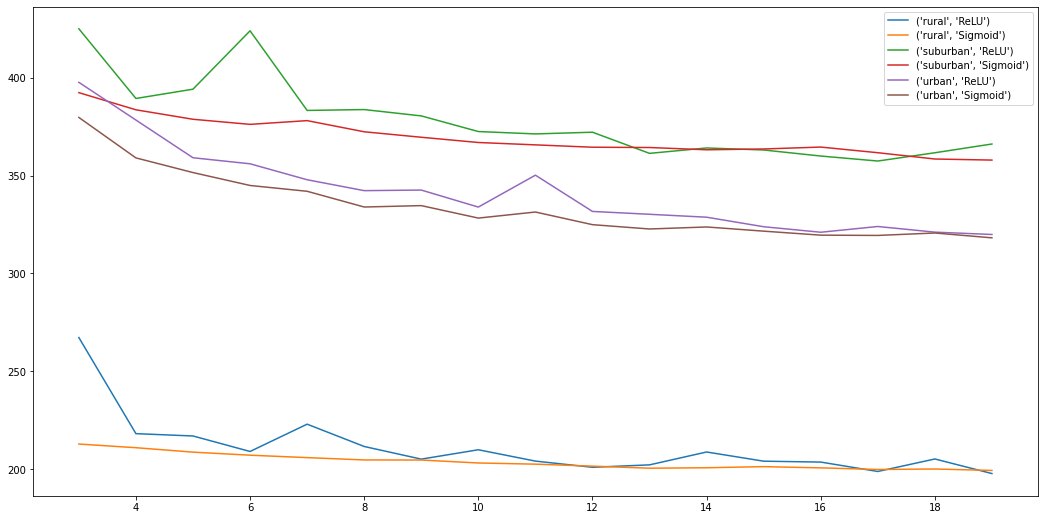

In [ ]:
summary['hidden_sizes'] = summary['name'].str[1:].str.split(']', expand=True)[0].astype(int)
summary['activations'] = summary['name'].str.split('_', expand=True)[1].str.split(', ', expand=True)[1].str[1:-2]
# summary = summary.sort_values(['urbanization', 'cv_score'])
summary = summary.sort_values('hidden_sizes', ascending=True)
summary.to_csv(root_path / 'summary.csv')
fig = plt.figure(figsize=(18, 9))
for label, Z in summary.groupby(['urbanization', 'activations']):
    plt.plot(Z['hidden_sizes'], Z['cv_score'], label=label)
plt.legend(loc=0)
plt.show()

In [ ]:
summary.query('activations=="Sigmoid"').groupby('hidden_sizes')['cv_score'].describe().sort_values('hidden_sizes')

,count,mean,std,min,25%,50%,75%,max
hidden_sizes,,,,,,,,
3,3.0,328.288769,100.204760,212.813887,296.251549,379.689212,386.026210,392.363209
4,3.0,317.850500,93.401770,210.937222,284.976982,359.016742,371.307138,383.597535
5,3.0,312.987382,91.358263,208.673882,280.101794,351.529706,365.144132,378.758557
6,3.0,309.400810,89.950080,207.111863,276.022401,344.932940,360.545284,376.157627
7,3.0,308.634584,90.805145,205.874944,273.918092,341.961240,360.014404,378.067568
8,3.0,303.658764,87.841409,204.686036,269.305529,333.925022,353.145128,372.365234
9,3.0,302.950901,86.911048,204.642041,269.640758,334.639475,352.105332,369.571188
10,3.0,299.431341,85.601683,203.135223,265.701464,328.267705,347.579399,366.891093
11,3.0,299.858982,86.019289,202.528262,266.947750,331.367237,348.524343,365.681448


In [ ]:
import torch
torch.manual_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"

def tensorify(T):
    if not torch.is_tensor(T):
        T = torch.FloatTensor(np.array(T).astype(float)).to(device)
    return T

class VotingPredictor(torch.nn.Module):
    def __init__(self, hidden_layers, activations, name=''):
        super().__init__()
        H = ut.listify(hidden_layers)
        A = ut.listify(activations)
        assert len(A) - len(H) == 1, 'activations must be one longer than hidden_layers'
        L = [len(feats), *H, 6]
        N = [x for k, f in enumerate(A) for x in [torch.nn.Linear(L[k], L[k+1]), f()]]
        self.nn = torch.nn.Sequential(*N)
        self.P = tensorify([[1,1,1,0,0,0],[0,0,0,1,1,1]]).T
        self.loss = {'train':[], 'test':[]}
        self.name = name

    def forward(self, W, X):
        self.props_race = self.nn(tensorify(X))
        self.votes_race = self.props_race * tensorify(W)
        self.votes_tot  = self.votes_race @ self.P
        return self.votes_tot

    def train(self, DFS, n_steps, plot=False):
        W = {s:tensorify(df[wghts]) for s,df in DFS.items()}
        X = {s:tensorify(df[feats]) for s,df in DFS.items()}
        Y = {s:tensorify(df[targs]) for s,df in DFS.items()}
        loss_fcn = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(self.nn.parameters())
        def f(s):
            loss = loss_fcn(self.forward(W[s], X[s]), Y[s])
            self.loss[s].append(np.sqrt(loss.item()))
            return loss
        for step in range(n_steps):
            with torch.no_grad():
                f('test')
            loss = f('train')
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    def predict(self, df):
        self.forward(df[wghts], df[feats])
        self.props_tot = self.votes_tot / self.votes_tot.sum(axis=1, keepdims=True)
        PR = pd.DataFrame(self.props_race.numpy(force=True), columns=props_race)
        VR = pd.DataFrame(self.votes_race.numpy(force=True), columns=votes_race)
        PT = pd.DataFrame(self.props_tot .numpy(force=True), columns=props_tot)
        VT = pd.DataFrame(self.votes_tot .numpy(force=True), columns=votes_tot)
        return pd.concat([df, VR, PR, VT, PT], axis=1)

    def plot(self, start=0):
        for s in ['test', 'train']:
            y = self.loss[s]
            x = np.arange(len(y))
            plt.plot(x[start:], y[start:], label=s)
        plt.legend()
        plt.title(self.name)
        plt.show()


grid = ut.cartesian({
    'hidden_layers':np.arange(3,4),
    'activations': [[torch.nn.ReLU, torch.nn.ReLU]]#, [torch.nn.ReLU, torch.nn.Sigmoid], [torch.nn.ReLU, torch.nn.Tanh]],
})

n_steps = 20000
n_steps = 1000
start = int(n_steps*.1)
for g in grid:
    g['cv'] = dict()
    for urb, urb_df in df.groupby('urbanization'):
        g['cv'][urb] = dict()
        for camp, camp_df in urb_df.groupby('campaign'):
            DFS = {'test':camp_df, 'train':urb_df.loc[urb_df.index.difference(camp_df.index)]}
            model = VotingPredictor(g['hidden_layers'], g['activations'], f'{urb}_{camp}').to(device)
            model.train(DFS, n_steps)
            # model.plot(start)
            g['cv'][urb][camp] = model
        g['cv'][urb]['score'] = np.mean([model.loss['test'][-1] for model in g['cv'][urb].values()])

        DFS = {'test':df, 'train':df}
        model = VotingPredictor(g['hidden_layers'], g['activations'], urb).to(device)
        model.train(DFS, n_steps)
        model.plot(start)
        # g['cv_score'] = np.mean([model.loss['test'][-1] for model in g['cv'].values()])
    # print(round(g['cv_score']), g['hidden_layers'], [f.__name__ for f in g['activations']])

    # DFS = {'test':df, 'train':df}
    # model = VotingPredictor(g['hidden_layers'], g['activations'], 'all').to(device)
    # model.train(DFS, n_steps)
    # model.plot(int(n_steps*.1))
    # g['model'] = model



In [ ]:
g = grid[0]
g.keys()
g['cv']['urban']['score'], g['cv']['suburban']['score'], g['cv']['rural']['score']

(819.5569331184068, 867.6506919251079, 512.00654156191)

In [ ]:
import torch
torch.manual_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"

def tensorify(T):
    if not torch.is_tensor(T):
        T = torch.FloatTensor(np.array(T).astype(float)).to(device)
    return T

class VotingPredictor(torch.nn.Module):
    def __init__(self, hidden_layers, activations, name=''):
        super().__init__()
        H = ut.listify(hidden_layers)
        A = ut.listify(activations)
        assert len(A) - len(H) == 1, 'activations must be one longer than hidden_layers'
        L = [len(feats), *H, 6]
        N = [x for k, f in enumerate(A) for x in [torch.nn.Linear(L[k], L[k+1]), f()]]
        self.nn = torch.nn.Sequential(*N)
        self.P = tensorify([[1,1,1,0,0,0],[0,0,0,1,1,1]]).T
        self.loss = {'train':[], 'test':[]}
        self.name = name

    def forward(self, W, X):
        self.props_race = self.nn(tensorify(X))
        self.votes_race = self.props_race * tensorify(W)
        self.votes_tot  = self.votes_race @ self.P
        return self.votes_tot

    def train(self, DFS, n_steps):
        W = {s:tensorify(df[wghts]) for s,df in DFS.items()}
        X = {s:tensorify(df[feats]) for s,df in DFS.items()}
        Y = {s:tensorify(df[targs]) for s,df in DFS.items()}
        loss_fcn = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(self.nn.parameters())
        def f(s):
            loss = loss_fcn(self.forward(W[s], X[s]), Y[s])
            self.loss[s].append(np.sqrt(loss.item()))
            return loss
        for step in range(n_steps):
            with torch.no_grad():
                f('test')
            loss = f('train')
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    def predict(self, df):
        self.forward(df[wghts], df[feats])
        self.props_tot = self.votes_tot / self.votes_tot.sum(axis=1, keepdims=True)
        PR = pd.DataFrame(self.props_race.numpy(force=True), columns=props_race)
        VR = pd.DataFrame(self.votes_race.numpy(force=True), columns=votes_race)
        PT = pd.DataFrame(self.props_tot .numpy(force=True), columns=props_tot)
        VT = pd.DataFrame(self.votes_tot .numpy(force=True), columns=votes_tot)
        return pd.concat([df, VR, PR, VT, PT], axis=1)

    def plot(self, start=0):
        for s in ['test', 'train']:
            y = self.loss[s]
            x = np.arange(len(y))
            plt.plot(x[start:], y[start:], label=s)
        plt.legend()
        plt.title(self.name)
        plt.show()


grid = ut.cartesian({
    'hidden_layers':np.arange(3,15),
    'activations': [[torch.nn.ReLU, torch.nn.ReLU], [torch.nn.ReLU, torch.nn.Sigmoid], [torch.nn.ReLU, torch.nn.Tanh]],
})

n_steps = 20000
# n_steps = 100
for g in grid:
    g['cv'] = dict()
    for campaign, G in df.groupby('campaign'):
        DFS = {'test':G, 'train':df.loc[df.index.difference(G.index)]}
        model = VotingPredictor(g['hidden_layers'], g['activations'], campaign).to(device)
        model.train(DFS, n_steps)
        # model.plot(int(n_steps*.1))
        g['cv'][campaign] = model
    g['cv_score'] = np.mean([model.loss['test'][-1] for model in g['cv'].values()])
    print(round(g['cv_score']), g['hidden_layers'], [f.__name__ for f in g['activations']])

    # DFS = {'test':df, 'train':df}
    # model = VotingPredictor(g['hidden_layers'], g['activations'], 'all').to(device)
    # model.train(DFS, n_steps)
    # model.plot(int(n_steps*.1))
    # g['model'] = model



In [ ]:
df['urbanization'] = df.groupby('campaign')['all_vap_pop_dens'].transform(lambda x: pd.qcut(x, 3, labels=['rural', 'suburban', 'urban']))


# dens = df['all_vap_pop_dens']
# df['urbanization'], cuts = pd.qcut(df['all_vap_pop_dens'], 3, retbins=True, labels=False)
# cuts[1:-1]

df.groupby('campaign')['urbanization'].value_counts().unstack()#.std(axis=1)